In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
class QueueMM2():
    def __init__(self, lbd, mu, cap=5): 
        
        self.lbd = lbd                        #каждые lbd минут поступает новое требование
        self.mu = mu                          #сервисное время 1/mu
        self.cap = cap
        
        self.clock = 0.0                      #simulation clock
        self.num_arrivals = 0                 #total number of arrivals
        self.next_arriv_time = self.gen_arrival_time()   #time of next arrival
        
        self.leaving_time1 = float('inf')     #departure time from server 1
        self.leaving_time2 = float('inf')     #departure time from server 2
        
        self.S1_state = 0                     #current state of server1 (0-free, 1-busy)
        self.S2_state = 0                     #current state of server2 (0-free, 1-busy)
        
        self.num_of_departures1=0             #number of customers served by server 1  
        self.num_of_departures2=0             #number of customers served by server 2 
        
        self.sum_serv_times1=0                #sum of service times by server 1
        self.sum_serv_times2=0                #sum of service times by server 2
        
        self.queue_length = 0                 #current number in queue
        self.lost_customers = 0               #customers who left without service
        self.waiting_customers = 0
        self.customers_in_queue_per_iter = np.array([]) #number of customers in queue per iteration
        
    def time_adv(self):                                                       
        t_next_event = min(self.next_arriv_time, self.leaving_time1, self.leaving_time2)  
        self.clock = t_next_event      
        if (self.next_arriv_time < self.leaving_time1) and (self.next_arriv_time < self.leaving_time2):
            self.Arrival()
        elif (self.next_arriv_time > self.leaving_time1) and (self.leaving_time1 < self.leaving_time2):
            self.Server1()
        else:
            self.Server2()     
        self.customers_in_queue_per_iter = np.append(self.customers_in_queue_per_iter, [self.queue_length])
            
    def Arrival(self):              
        self.num_arrivals += 1

        if (self.queue_length == 0):                      #schedule next departure or arrival depending on state of servers
            if (self.S1_state==1 and self.S2_state==1):        #both servers are busy
                self.queue_length += 1
                self.next_arriv_time = self.clock + self.gen_arrival_time()
            elif (self.S1_state==0 and self.S2_state==0):      #both servers are free
                if (np.random.choice([0,1])==1):
                    self.S1_state = 1
                    self.service_time1 = self.gen_service_time()
                    self.sum_serv_times1 += self.service_time1
                    self.leaving_time1 = self.clock + self.service_time1
                    self.next_arriv_time = self.clock + self.gen_arrival_time()
                else:
                    self.S2_state = 1
                    self.service_time2 = self.gen_service_time()
                    self.sum_serv_times2 += self.service_time2
                    self.leaving_time2 = self.clock + self.service_time2
                    self.next_arriv_time = self.clock + self.gen_arrival_time()
            elif (self.S1_state==0 and self.S2_state==1):       #if server 2 is busy customer goes to server 1
                self.S1_state = 1
                self.service_time1 = self.gen_service_time()
                self.sum_serv_times1 += self.service_time1
                self.leaving_time1 = self.clock + self.service_time1
                self.next_arriv_time = self.clock + self.gen_arrival_time()
            else:                                               #if server 1 is busy customer goes to server 2
                self.S2_state = 1
                self.service_time2 = self.gen_service_time()
                self.sum_serv_times2 += self.service_time2
                self.leaving_time2 = self.clock + self.service_time2
                self.next_arriv_time = self.clock + self.gen_arrival_time()
        elif (self.queue_length<self.cap and self.queue_length>=1): #if queue length is less than 5 generate next arrival and make customer join queue
            self.queue_length += 1
            self.waiting_customers += 1
            self.next_arriv_time = self.clock + self.gen_arrival_time()
        elif (self.queue_length>=self.cap):                          #if queue length is >=5 equal prob to leave or stay
#             if (np.random.choice([0,1])==1): 
#                 self.queue_length += 1 
#                 self.next_arriv_time = self.clock + self.gen_arrival_time()
#             else:
            self.lost_customers += 1
            self.next_arriv_time = self.clock + self.gen_arrival_time()
                
    def Server1(self):                #departure from server 2
        self.num_of_departures1 += 1
        if (self.queue_length>0):
            self.service_time1 = self.gen_service_time()
            self.sum_serv_times1 += self.service_time1
            self.leaving_time1 = self.clock + self.service_time1
            self.queue_length -= 1
        else:
            self.leaving_time1 = float('inf') 
            self.S1_state = 0                  
    
    def Server2(self):                #departure from server 1
        self.num_of_departures2 += 1
        if (self.queue_length>0):
            self.service_time2 = self.gen_service_time()
            self.sum_serv_times2 += self.service_time2
            self.leaving_time2 = self.clock + self.service_time2
            self.queue_length -= 1
        else:
            self.leaving_time2 = float('inf')
            self.S2_state = 0
            
    def gen_arrival_time(self):            #function to generate arrival times using poisson distribution
        return (np.random.poisson(self.lbd))
    
    def gen_service_time(self):            #function to generate service time for servers using exponential distribution
        return (np.random.exponential(1./self.mu))
    

In [124]:
s=QueueMM2(10,0.1)
df=pd.DataFrame(columns=['Average interarrival time',
                         'Average service time server1', 'Average service time server2',

                         'Lost Customers', 'Queue length'])

data = {
    ''
}

for i in range(100):
    np.random.seed(i)
    s.__init__(0.5,2)
    while s.clock <= 1000:
        s.time_adv()
    a = pd.Series([s.clock/s.num_arrivals, 
                   s.sum_serv_times1/s.num_of_departures1, s.sum_serv_times2/s.num_of_departures2,
                   s.lost_customers, s.queue_length], index=df.columns)
    df = df.append(a, ignore_index=True)   
    
df.to_excel('results.xlsx')   

In [125]:
df

,Average interarrival time,Average service time server1,Average service time server2,Lost Customers,Queue length
0,0.511740,0.507221,0.500487,88.0,3.0
1,0.505838,0.500110,0.503798,112.0,2.0
2,0.491008,0.489531,0.460656,122.0,0.0
3,0.489391,0.515884,0.543865,143.0,0.0
4,0.535363,0.500902,0.506288,57.0,2.0
...,...,...,...,...,...
95,0.509206,0.518218,0.464236,78.0,0.0
96,0.507671,0.511270,0.518201,102.0,0.0
97,0.543278,0.504433,0.502144,83.0,1.0
98,0.484075,0.498304,0.495880,137.0,2.0


# Эксперименты с различными параметрами

В ходе экспериментов будем вычислять следующие метрики:
 - Среднее время пребывания требования в системе
 - Вероятность отказа (требование пришло, а очередь заполнена)
 - Вероятность ожидания (требование пришло, а очередь непустая)
 - Среднее количество заявок в очереди

In [237]:
metrics_titles = ['Average time in the system',
        'Probabily of non-serving',
        'Probability of waiting',
        'Average count of customers in queue']

In [344]:
def run_mm2_queue(lmd, mu, cap, n_iter, s = 42):
    system = QueueMM2(lmd, mu, cap)
    np.random.seed()
    
    for i in range(n_iter):
        system.time_adv()
    
    metrics = {
        'avg_time_in_system': np.round(system.clock / system.num_arrivals,3),
        'prob_of_non_serving': np.round(system.lost_customers / system.num_arrivals,3),
        'prob_of_waiting': np.round(system.waiting_customers / system.num_arrivals,3),
        'avg_customers_count_in_queue': np.mean(system.customers_in_queue_per_iter)
    }
    
    params = {
        'Lambda': lmd,
        'Mu': mu,
        'Rough': lmd/(2*mu),
        'Arrived customers': system.num_arrivals
    }
    
    return metrics

In [336]:
def draw_metrics(params, test_metrics, param_name):
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Метрики в зависимости от параметра {param_name}')

    i = 0

    for metric_name, values in test_metrics.items():
        plt.subplot(221+i)   
        plt.plot(params, values, 'o-')
        plt.title(metrics_titles[i])
        plt.xlabel(param_name)
        plt.ylabel(metric_name)
        plt.grid()
        i+=1


    plt.show()

## Рассмотрим случай для $\lambda \leq \mu$

Будем менять $\lambda$.

In [365]:
mu = 3
int_size = 0.01
lambdas = np.arange(0, mu/2, int_size)
capacity = 5

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list()
}

for i in range(len(lambdas)):
    metrics = run_mm2_queue(lambdas[i], mu, capacity, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])

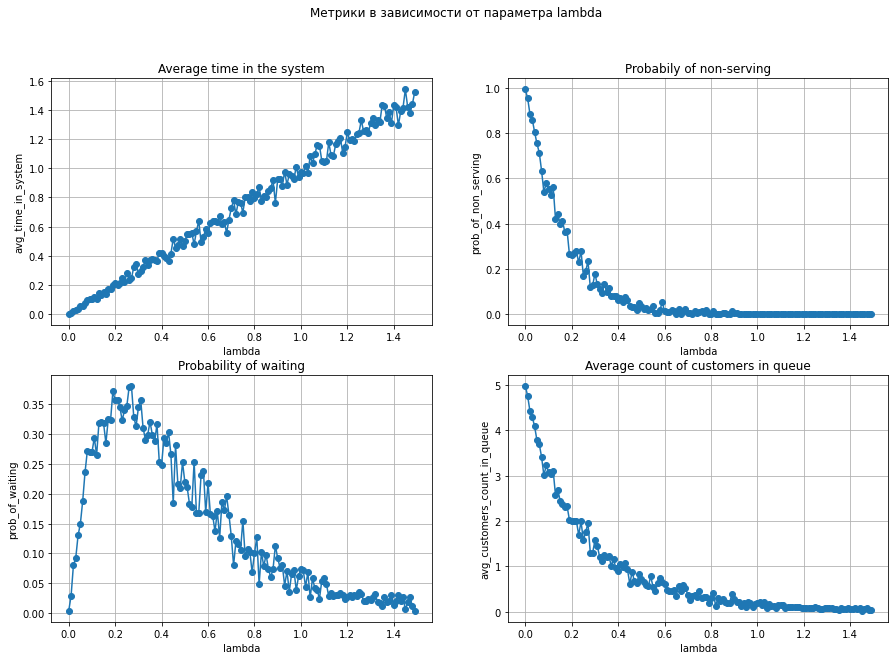

In [366]:
draw_metrics(lambdas, test_metrics, 'lambda')

Зафиксируем $\mu, \lambda$ и посмотрим, как меняются графики при изменении размера очереди.

In [367]:
mu = 3
lmd = 0.4
capacity = np.arange(1,50,1)

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list()
}

for i in range(len(capacity)):
    metrics = run_mm2_queue(lmd, mu, capacity[i], 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])

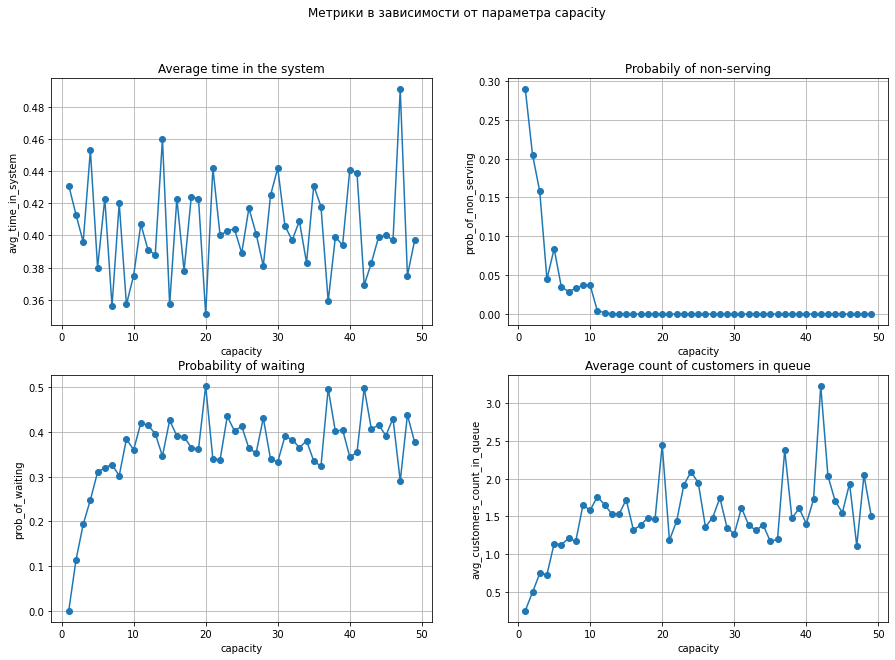

In [368]:
draw_metrics(capacity, test_metrics, 'capacity')

## $\lambda > \mu$

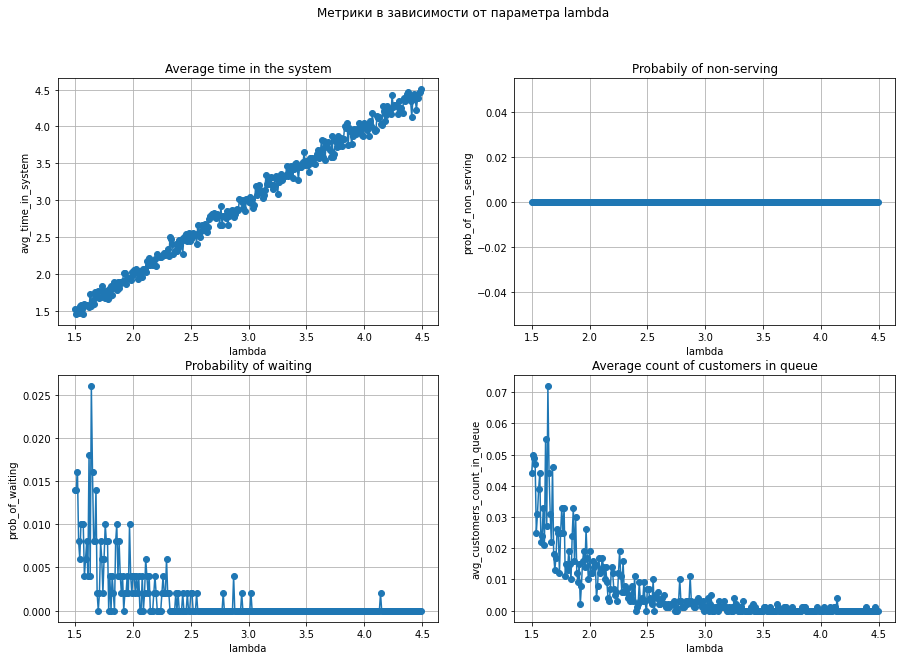

In [372]:
mu = 3
int_size = 0.01
lambdas = np.arange(mu/2, 3*mu/2, int_size)
capacity = 5

test_metrics = {
    'avg_time_in_system': list(),
    'prob_of_non_serving': list(),
    'prob_of_waiting': list(),
    'avg_customers_count_in_queue': list()
}

for i in range(len(lambdas)):
    metrics = run_mm2_queue(lambdas[i], mu, capacity, 1000)
    test_metrics['avg_time_in_system'].append(metrics['avg_time_in_system'])
    test_metrics['prob_of_non_serving'].append(metrics['prob_of_non_serving'])
    test_metrics['prob_of_waiting'].append(metrics['prob_of_waiting'])
    test_metrics['avg_customers_count_in_queue'].append(metrics['avg_customers_count_in_queue'])


draw_test_metrics(lambdas, test_metrics, 'lambda')